In [4]:
import cv2
import torch
import numpy as np
from diffusers import StableDiffusionPipeline
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline

def dummy_safety_checker(images, clip_input):
    return images, [False] * len(images)

# Load the StableDiffusion model.
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to("cuda")
pipe.safety_checker = dummy_safety_checker  # Override filter

# Hyperparameters
alpha = 0.07
threshold = 0.05
prompt = "a very high quality image"

def encode_latents(image):
    """ Encode an image into Stable Diffusion's latent space """
    image = image.unsqueeze(0).to("cuda")  # Ensure batch dimension
    latents = pipe.vae.encode(image).latent_dist.sample()
    return latents

def decode_latents(latents):
    """ Decode latents back to an image """
    image = pipe.vae.decode(latents).sample
    return image.squeeze(0).cpu()  # Remove batch dimension

def dct2(b):
    return cv2.dct(np.float32(b))

def invdct2(b):
    return cv2.idct(b)

def embed_message(latents, message, alpha=alpha):
    latents_np = latents.cpu().numpy()
    message_np = message.cpu().numpy()

    print(f"Initial Latents: mean={latents.mean().item()}, std={latents.std().item()}")

    latents_np = np.clip(latents_np, -1, 1)

    for i in range(4):
        latents_np[0, i, :, :] = dct2(latents_np[0, i, :, :])
        latents_np[0, i, :, :] = np.clip(latents_np[0, i, :, :], -1, 1)

        print(f"After DCT - Latent {i}: mean={latents_np[0, i].mean()}, std={latents_np[0, i].std()}")  # Debug step 2
        latents_np[0, i, -8:, -8:] += alpha * message_np[0, i, -8:, -8:] * latents_np[0, i, -8:, -8:]
        print(f"After Message Embedding - Latent {i}: mean={latents_np[0, i].mean()}, std={latents_np[0, i].std()}")  # Debug step 3
        latents_np[0, i, :, :] += np.random.uniform(-1e-6, 1e-6, size=latents_np[0, i, :, :].shape)
        print(f"After IDCT - Latent {i}: mean={latents_np[0, i].mean()}, std={latents_np[0, i].std()}")  # Debug step 4

        if np.isnan(latents_np[0, i]).any():
            print(f"NaN detected after IDCT in channel {i}, replacing with zeros.")
            latents_np[0, i] = np.nan_to_num(latents_np[0, i])  # Replace NaNs with 0

    latents_modded = torch.tensor(latents_np, dtype=torch.float32).to(latents.device)
    latents_modded = (latents_modded - latents_modded.mean()) / (latents_modded.std() + 1e-8)
    latents_modded = latents_modded * 0.18215

    print(f"🔹 Final Latents After Normalization: mean={latents_modded.mean().item()}, std={latents_modded.std().item()}")

    std = latents_modded.std()
    if std < 1e-6:  # If std is too small, prevent division by tiny value
        std = 1.0

    latents_modded = latents_modded / std

    return latents_modded

def get_message(latents, threshold=threshold):
    # Detach the tensor from the computation graph before converting to NumPy
    latents_np = latents.cpu().detach().numpy()
    extracted_message = np.zeros_like(latents_np)

    for i in range(4):
        dct_coeffs = dct2(latents_np[0, i, :, :])
        extracted_message[0, i, -8:, -8:] = (dct_coeffs[-8:, -8:] > threshold).astype(int)

    return extracted_message

def gen_img(message, prompt=prompt, alpha=alpha):
    latents = torch.randn(1, 4, 64, 64).to('cuda')
    latents_w_message = embed_message(latents, message, alpha)

    with torch.no_grad():
        stego_img = pipe(prompt=prompt, latents=latents_w_message).images[0]

    return stego_img, latents_w_message

def get_message_from_stego(stego_img, threshold=threshold):
    image_tensor = torch.tensor(np.array(stego_img).astype(np.float32) / 127.5 - 1).permute(2, 0, 1).to("cuda")
    image_latents = encode_latents(image_tensor)
    extracted_message = get_message(image_latents, threshold)

    return extracted_message


def get_message_accuracy(original_message, extracted_message):
    """
    Calculate the accuracy of the extracted message compared to the original message.
    """
    # Flatten the messages for comparison
    original_flat = original_message.flatten()
    extracted_flat = extracted_message.flatten()

    # Calculate the number of matching bits
    correct_bits = np.sum(original_flat == extracted_flat)
    total_bits = original_flat.size

    # Calculate accuracy as a percentage
    accuracy = (correct_bits / total_bits) * 100
    return accuracy

message = torch.randint(0, 2, (1, 4, 64, 64)).float().to("cuda")
stego_image, _ = gen_img(message, alpha=alpha)
extracted_message = get_message_from_stego(stego_image, threshold=threshold)

accuracy = get_message_accuracy(message.cpu().numpy(), extracted_message)
print(f"Message Extraction Accuracy: {accuracy:.2f}%")


plt.imshow(stego_image)
plt.axis('off')
plt.show()

c:\Users\huds0\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.17it/s]


Initial Latents: mean=0.001646573655307293, std=1.0102202892303467
After DCT - Latent 0: mean=0.00873502716422081, std=0.6089093089103699
After Message Embedding - Latent 0: mean=0.008759861811995506, std=0.6092541813850403
After IDCT - Latent 0: mean=0.008759867399930954, std=0.6092542409896851
After DCT - Latent 1: mean=-0.00019442476332187653, std=0.6182243824005127
After Message Embedding - Latent 1: mean=-0.00019955914467573166, std=0.6186514496803284
After IDCT - Latent 1: mean=-0.0001995619386434555, std=0.6186514496803284
After DCT - Latent 2: mean=-0.01521315984427929, std=0.611559271812439
After Message Embedding - Latent 2: mean=-0.015226699411869049, std=0.6119216084480286
After IDCT - Latent 2: mean=-0.015226689167320728, std=0.6119216084480286
After DCT - Latent 3: mean=0.0017682760953903198, std=0.6160196661949158
After Message Embedding - Latent 3: mean=0.0017213299870491028, std=0.6163034439086914
After IDCT - Latent 3: mean=0.0017213355749845505, std=0.616303443908691

100%|██████████| 50/50 [00:10<00:00,  4.69it/s]


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

🔹 Generating Image Without Modification - Latents mean=-0.0037814020179212093, std=1.0028631687164307


100%|██████████| 50/50 [04:36<00:00,  5.54s/it]


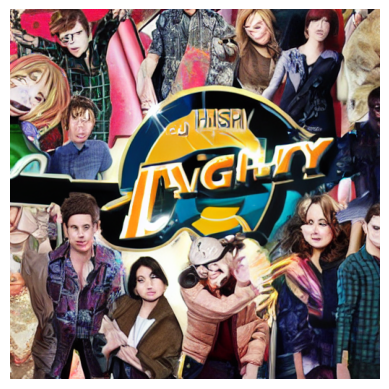

In [ ]:
def gen_img_no_modification(prompt=prompt):
    latents = torch.randn(1, 4, 64, 64).to("cuda")  # Initial latent noise

    print(f"🔹 Generating Image Without Modification - Latents mean={latents.mean().item()}, std={latents.std().item()}")

    with torch.no_grad():
        stego_img = pipe(prompt=prompt, latents=latents).images[0]

    return stego_img


stego_image_no_mod = gen_img_no_modification()
plt.imshow(stego_image_no_mod)
plt.axis("off")
plt.show()
